The idea here is to reduce data dimensionality to two values and see how well the samples separate. I have already shown [**here**](https://www.kaggle.com/competitions/playground-series-s5e7/discussion/587445) that the two data classes separate well after training. But will they separate well without training?

A go-to method here is Principal Component Analysis (PCA), but it doesn't work with missing values. Instead, I will use [**Truncated SVD**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (tSVD) because it works with missing values. tSVD does not need data to be normalized. However, we will eventually have to convert the data into a sparse matrix, and for that missing values must be converted to 0. By normalizing the data we convert zeros from original data into other values, so later we can sparsify the matrix.

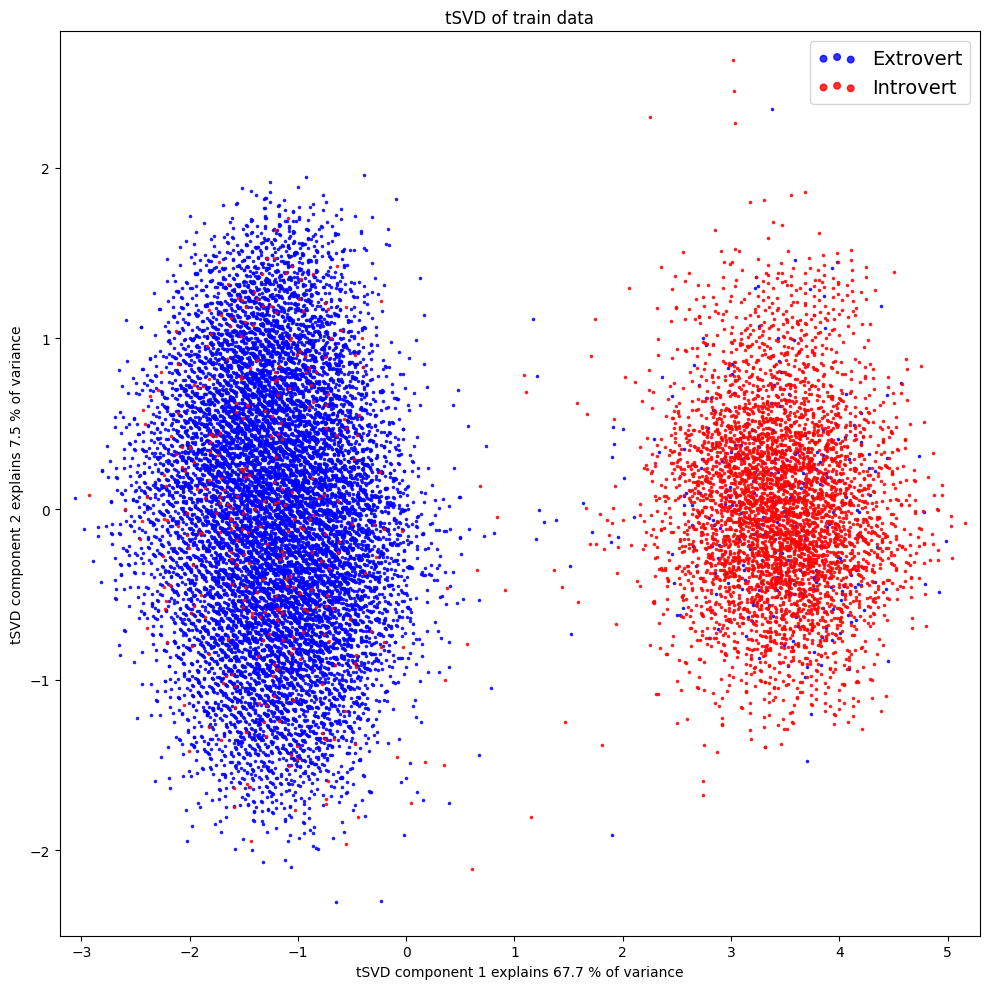

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from scipy import sparse

train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')

# Preparing the data for Truncated SVD
# All features must have numerical values
X_train = train_df.drop(columns=['id', 'Personality'], axis=1)
X_train['Stage_fear'].replace({'No': 0, 'Yes': 1}, inplace=True)
X_train['Drained_after_socializing'].replace({'No': 0, 'Yes': 1}, inplace=True)

X_test = test_df.drop(columns=['id'], axis=1)
X_test['Stage_fear'].replace({'No': 0, 'Yes': 1}, inplace=True)
X_test['Drained_after_socializing'].replace({'No': 0, 'Yes': 1}, inplace=True)

# By scaling the data we convert current 0 values into different number
# and later we replace NaNs with zeros before making a sparse matrix.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled[np.isnan(X_scaled)] = 0
X_test_scaled = scaler.transform(X_test)
X_test_scaled[np.isnan(X_test_scaled)] = 0

# Reduce the data to 2 dimensions
n_comp = 2
svd = TruncatedSVD(n_components=n_comp)
X_svd = svd.fit_transform(sparse.csr_matrix(X_scaled))

# Create a DataFrame for the tSVD results
svd_df = pd.DataFrame(data=X_svd, columns=['tSVD1', 'tSVD2'])
svd_df.to_csv('train_SVD_components.csv', index=False)

# Plotting the tSVD results
y = train_df['Personality'].replace({'Extrovert': 0, 'Introvert': 1}).values
target_names = np.unique(y)
colors = ['blue', 'red']

plt.figure(1, figsize=(10, 10))
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(svd_df.values[y == i, 0], svd_df.values[y == i, 1], color=color, alpha=.8, s=10,
                label=target_name, marker='.')
plt.title("tSVD of train data")
plt.xlabel("tSVD component 1 explains %.1f %% of variance" % (svd.explained_variance_ratio_[0] * 100.0))
plt.ylabel("tSVD component 2 explains %.1f %% of variance" % (svd.explained_variance_ratio_[1] * 100.0))
plt.legend(['Extrovert', 'Introvert'], loc='best', shadow=False, scatterpoints=3, markerscale=3.0, prop={'size':14})
plt.xlim(-3.2, 5.3)
plt.ylim(-2.5, 2.8)
plt.tight_layout()
plt.savefig('tSVD_train_data.png', dpi=300)
plt.show()
plt.close()

Let's use the fitted tSVD for test data and plot the result.

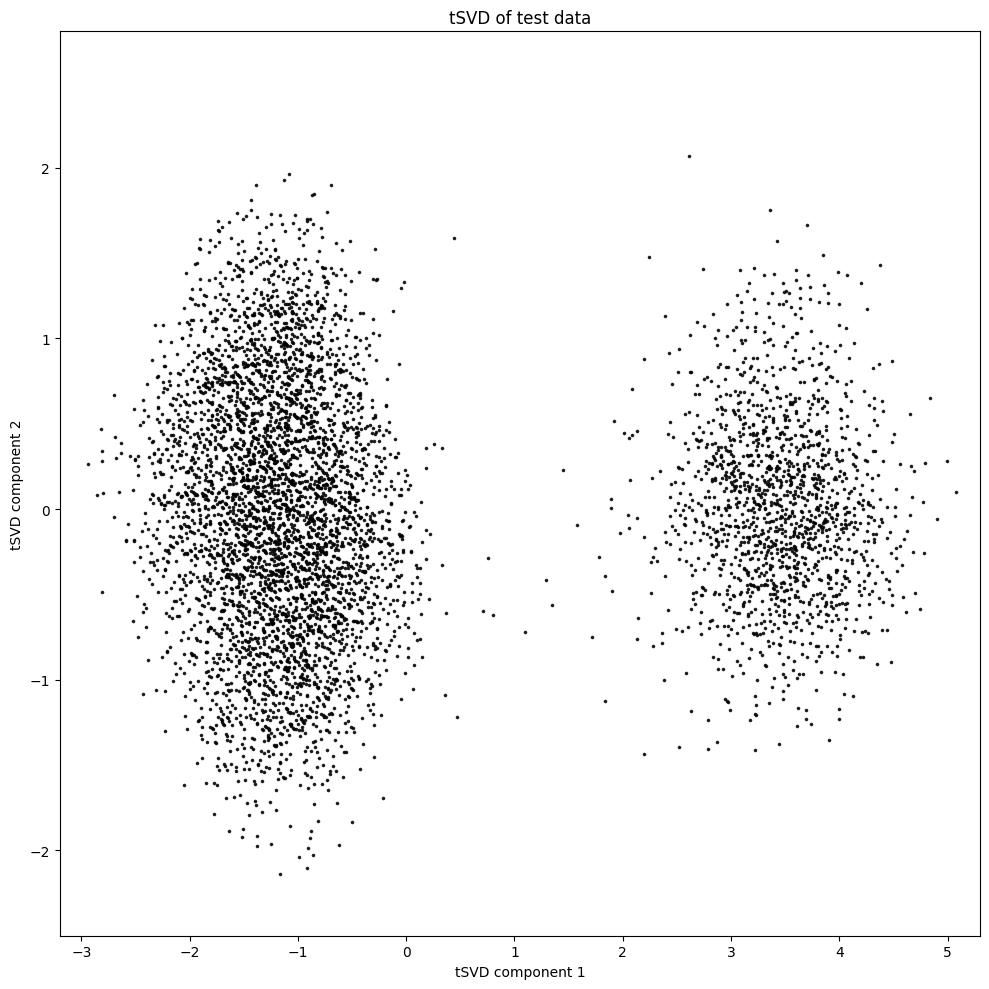

In [2]:
X_test_svd = svd.transform(sparse.csr_matrix(X_test_scaled))
svd_test_df = pd.DataFrame(data=X_test_svd, columns=['tSVD1', 'tSVD2'])
svd_test_df.to_csv('test_SVD_components.csv', index=False)

plt.figure(2, figsize=(10, 10))
plt.scatter(svd_test_df.values[:,0], svd_test_df.values[:,1], c='k', alpha=.8, s=10, marker='.')
plt.title("tSVD of test data")
plt.xlabel("tSVD component 1")
plt.ylabel("tSVD component 2")
plt.xlim(-3.2, 5.3)
plt.ylim(-2.5, 2.8)
plt.tight_layout()
plt.savefig('tSVD_test_data.png', dpi=300)
plt.show()
plt.close()


Unsurprisingly, we get the same plot as for train data, except that samples have no labels.

Now, what would be the accuracy on train data if we divide the dataset down the middle (a value of 1 on the x axis), and label all the samples on the left side as extroverts, and everything on the right side as introverts?

In [3]:
X_train['Personality'] = 'Extrovert'
X_train.loc[svd_df['tSVD1'] > 1.0, 'Personality'] = 'Introvert'
print('\n Accuracy: %.6f' % (accuracy_score(train_df.Personality, X_train.Personality)) )



 Accuracy: 0.968905


That score looks good. We will do the same for the test data and submit the resulting prediction. It should score `0.972469`, which is not bad given that we have done no real training on this dataset.

In [4]:
submission['Personality'] = 'Extrovert'
submission.loc[svd_test_df['tSVD1'] > 1.0, 'Personality'] = 'Introvert'
submission.to_csv('submission.csv', index=False)
